In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from tqdm.auto import tqdm
from colorama import Fore, Style

In [3]:
import sys
sys.path.append("scripts")
import rr_em

from berp.util import time_to_sample

## Generate synthetic data

In [4]:
# Establish parameters used to synthesize data
# Obviously these will not be used during inference!

coef_mean = torch.tensor([-1.])
coef_sigma = torch.tensor([0.1])
params = rr_em.rr.ModelParameters(
    lambda_=pyro.deterministic("lambda", torch.tensor(1.0)),
    confusion=rr_em.generator.phoneme_confusion,
    threshold=pyro.sample("threshold",
                          dist.Beta(1.2, 1.2)),

    # NB only used for generation, not in model
    a=pyro.deterministic("a", torch.tensor(0.2)),  # unif_categorical_rv("a", torch.tensor([0.3, 0.4, 0.5])),
    b=pyro.deterministic("b", torch.tensor(0.1)), # unif_categorical_rv("b", torch.tensor([0.05, 0.1, 0.15, 0.2])),
    coef=pyro.deterministic("coef", coef_mean),  # pyro.sample("coef", dist.Normal(coef_mean, coef_sigma)),
    sigma=pyro.deterministic("sigma", torch.tensor(5.0)),
    # sigma=pyro.sample("sigma", dist.Uniform(0.5, 1.2))
    # sigma=torch.tensor(1.0),
)

print(f"{Style.BRIGHT}Critical parameters:{Style.RESET_ALL}")
print("Threshold:\t", params.threshold.item())
print("Noise sigma:\t", params.sigma.item())

Critical parameters:
Threshold:	 0.4433697760105133
Noise sigma:	 5.0


In [5]:
epoch_window = (0.0, 1.0)
stim = rr_em.stimulus.RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=params.confusion.shape[0],
                                              word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=epoch_window, include_intercept=False, sample_rate=48)
dataset = rr_em.generator.sample_dataset(params, stim, **ds_args)
test_dataset = rr_em.generator.sample_dataset(dataset.params, stim, **ds_args)

### Visualize characteristic response

This is the shape of the word recognition response used in the data that we wish to infer:

Text(0.5, 1.0, 'Characteristic response in synthetic dataset')

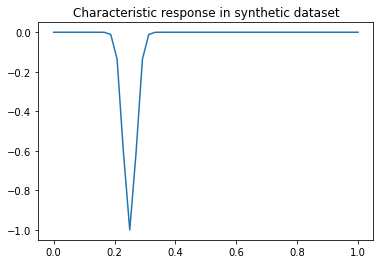

In [6]:
from berp.generators.response import simple_gaussian
xs, ys = simple_gaussian(params.b, params.a, dataset.sample_rate)
ys = coef_mean[-1] * ys
plt.plot(xs, ys)

plt.title("Characteristic response in synthetic dataset")

### Visualize epoched data

In [7]:
# Epoch data.
epoch_tmin, epoch_tmax = torch.tensor(epoch_window)
epoch_samples = time_to_sample(epoch_tmax - epoch_tmin, dataset.sample_rate)
Y_epoch = torch.zeros((dataset.X_variable.shape[0], epoch_samples, dataset.Y.shape[-1]))
for i, word_onset in enumerate(dataset.word_onsets):
    word_onset_sample = time_to_sample(word_onset, dataset.sample_rate)
    word_offset_sample = word_onset_sample + epoch_samples
    Y_epoch[i, :, :] = dataset.Y[word_onset_sample:word_offset_sample, :]

Text(0.5, 0, 'Epoch time')

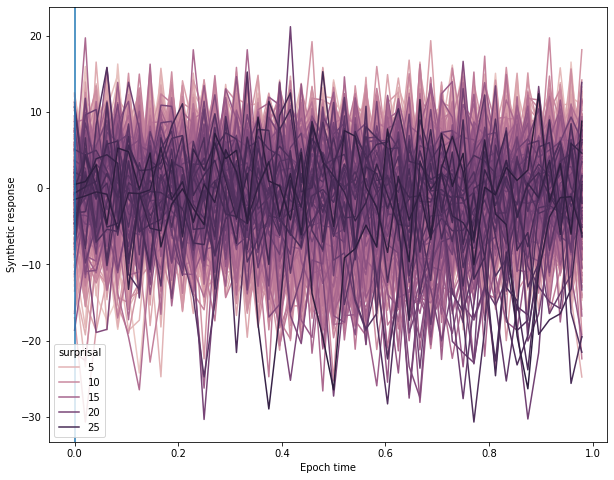

In [8]:
to_plot = pd.DataFrame(Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_variable[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)

plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

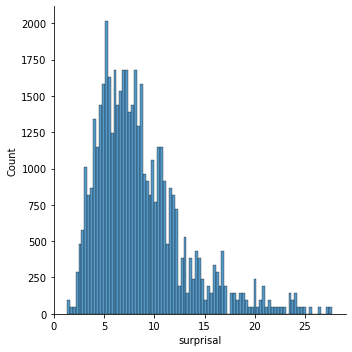

In [9]:
sns.displot(to_plot.surprisal)

Text(0.5, 0, 'Epoch time')

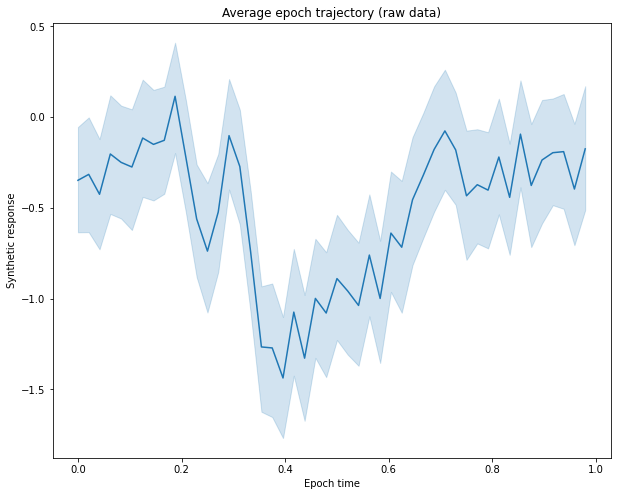

In [10]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")

plt.title("Average epoch trajectory (raw data)")
plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [47]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
tmin, tmax = epoch_window
n_features = dataset.X_variable.shape[1] + dataset.X_ts.shape[1]
n_outputs = 1
encoder = rr_em.TemporalReceptiveField(tmin, tmax, dataset.sample_rate,
                                       n_outputs=n_outputs,
                                       feature_names=n_features,
                                       alpha=0)
coefs = torch.zeros((n_splits, n_features, len(encoder.delays_), n_outputs))

X_scatter = rr_em.rr.scatter_response_model(
    dataset.X_variable,
    dataset.X_ts,
    torch.zeros(dataset.X_variable.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])

idxs = torch.arange(X_scatter.shape[0])

split_size = X_scatter.shape[0] // n_splits
split_offsets = torch.arange(n_splits) * split_size
for i_split, offset in enumerate(tqdm(split_offsets)):
    idxs_i = idxs[offset:offset + split_size]
    X_i = X_scatter[idxs_i]
    X_i[:, 1] += torch.randn(X_i[:, 1].shape)
    encoder_i = encoder.fit(X_scatter[idxs_i], dataset.Y[idxs_i])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
coef_df = pd.DataFrame(coefs[:, 0, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,-0.049618,0.0
1,1,0,-0.008555,0.0
2,2,0,0.035306,0.0
3,3,0,-0.061032,0.0
4,4,0,0.015462,0.0
...,...,...,...,...
485,5,48,-0.018564,1.0
486,6,48,-0.045463,1.0
487,7,48,0.010745,1.0
488,8,48,-0.122350,1.0


Text(0.5, 0, 'Epoch time')

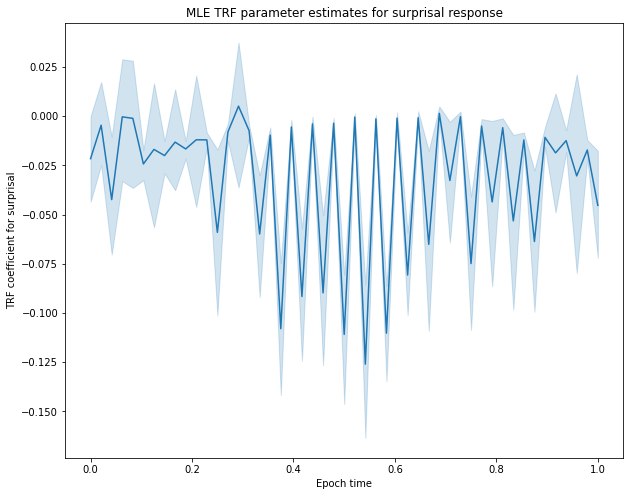

In [49]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

plt.title("MLE TRF parameter estimates for surprisal response")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

## EM regression with latent recognition

In [50]:
param_grid = [rr_em.get_parameters() for _ in range(50)]

In [51]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=50, trf_alpha=1e-2,
                                 epoch_window=(tmin, tmax),
                                 early_stopping_patience=3)

  0%|          | 0/50 [00:00<?, ?it/s]

In [52]:
coef_df = pd.DataFrame(torch.stack(encoders)[:, 0, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,0.005220,0.0
1,1,0,0.029341,0.0
2,2,0,0.021628,0.0
3,3,0,0.021628,0.0
4,4,0,0.025927,0.0
...,...,...,...,...
387,3,48,-0.056750,1.0
388,4,48,-0.032077,1.0
389,5,48,-0.096464,1.0
390,6,48,-0.096045,1.0


Text(0.5, 0, 'Epoch time')

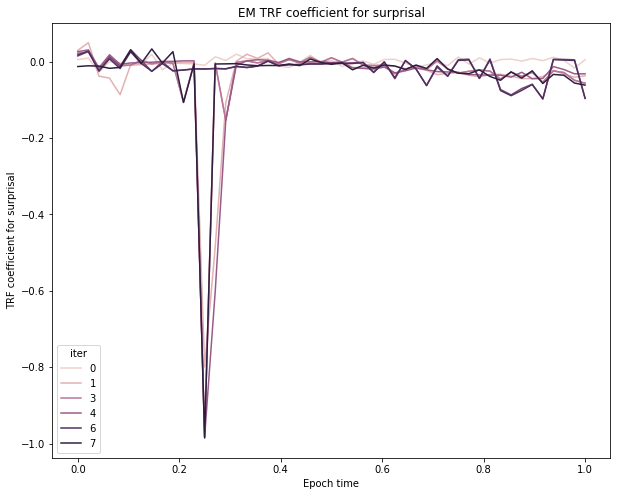

In [53]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

Text(0.5, 1.0, 'Distribution over weight grid, averaged over iterations')

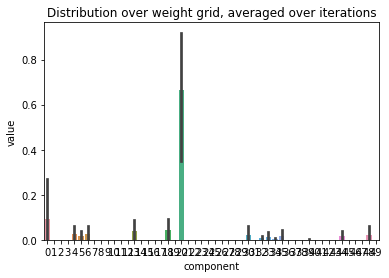

In [54]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

plt.title("Distribution over weight grid, averaged over iterations")

In [55]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [56]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0    0.752074
1    0.432380
2    0.432380
3    0.432380
4    0.432380
5    0.444993
6    0.464479
dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

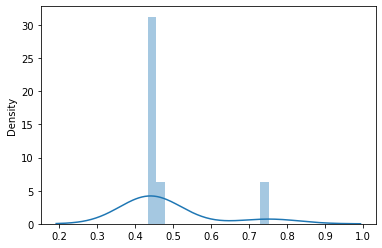

In [57]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [58]:
dataset.params.threshold

tensor(0.4434)